In [13]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.7.0


## Import InceptionNet model

In [18]:
inet_model = inc_net.InceptionV3()

In [19]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

('n01677366', 'common_iguana', 0.8835052)
('n01693334', 'green_lizard', 0.06051468)
('n01688243', 'frilled_lizard', 0.0074986396)
('n01687978', 'agama', 0.0060893903)
('n01685808', 'whiptail', 0.0021403583)


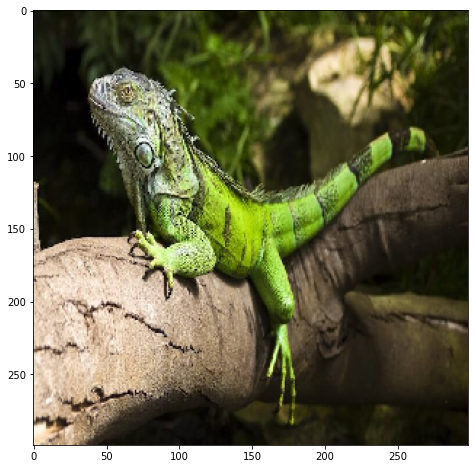

In [20]:
images = transform_img_fn([os.path.join('data','iguana.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.figure(figsize = (8,8))
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## See the segmentations 

In [21]:
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries

Segmentation on original image
# of segmentations: 88


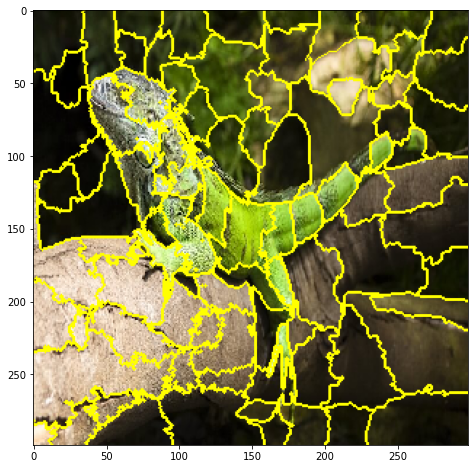

In [187]:
image = images[0]
segments = quickshift(image / 2 + 0.5, kernel_size = 4, max_dist = 13, ratio=0.3, random_seed = 1234)
print("Segmentation on original image")

print("# of segmentations: " + str(len(np.unique(segments))))
plt.figure(figsize = (8,8))
plt.imshow(mark_boundaries(image / 2 + 0.5, segments))

## Get prediction index

In [188]:
# Get the top 5 predictions
decode_predictions(preds, top=5)

[[('n01677366', 'common_iguana', 0.8835052),
  ('n01693334', 'green_lizard', 0.06051468),
  ('n01688243', 'frilled_lizard', 0.0074986396),
  ('n01687978', 'agama', 0.0060893903),
  ('n01685808', 'whiptail', 0.0021403583)]]

In [189]:
# Get the corresponding top 10 indices
top_5_idx = list(np.argsort(preds[0])[-5:])
top_5_idx.reverse()
top_5_idx

[39, 46, 43, 42, 41]

## Get masks from segmentations

In [190]:
# Let's experiment with two kinds of masks:
#   1. Mean color of the segment
#   2. Single color masks
fudged_image = image.copy()

fudged_image[:] = 0

# for x in np.unique(segments):
#         fudged_image[segments == x] = (
#             np.mean(image[segments == x][:, 0]),
#             np.mean(image[segments == x][:, 1]),
#             np.mean(image[segments == x][:, 2]))

In [191]:
# Create array of 1's and 0's as mask to hide partial image. 1 means show segment as is and 0 means hide segment.
n_features = np.unique(segments).shape[0]
mask_bin = np.array([random.randint(0, 1) for x in range(n_features)])

In [192]:
import copy
def get_masked_image(image, fudged_image, mask_bin, segments):
    temp = copy.deepcopy(image)
    zeros = np.where(mask_bin == 0)[0]
    mask = np.zeros(segments.shape).astype(bool)
    for z in zeros:
        mask[segments == z] = True
    temp[mask] = fudged_image[mask]
    return temp

In [193]:
masked_image = get_masked_image(image, fudged_image, mask_bin, segments)

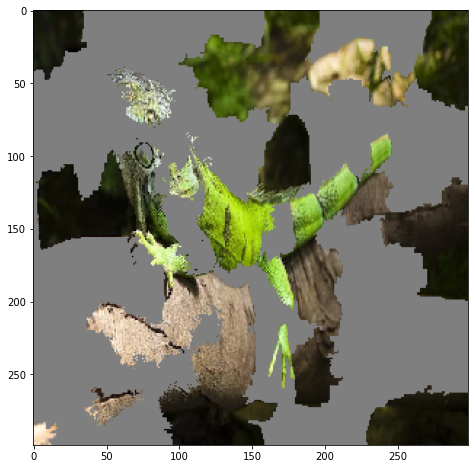

In [194]:
plt.figure(figsize = (8,8))
plt.imshow(masked_image / 2 + 0.5)

## Get probability for the class we are interested in

In [195]:
# Let's use predicted probability for each index
def get_idx_prob_pred(index, masked_image, model):
    preds =  model.predict(np.array([masked_image]))
    prob = preds[0][index]
    return prob, preds

In [196]:
get_idx_prob_pred(39, masked_image, inet_model)[0]

0.00084641867

## MCMC step

In [197]:
def get_new_step(mask_bin, num_samples=10):
    sample_idx = random.sample(range(len(mask_bin)), num_samples)
    new_mask_bin = mask_bin.copy()
    for idx in sample_idx:
        new_mask_bin[idx] = (mask_bin[idx] + 1) %  2
    return new_mask_bin

In [198]:
get_new_step(mask_bin)

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

## MCMC algorithm

In [199]:
from tqdm import tqdm
def MCMC(total_iters, burn_in_iters, step_len, index_of_interest, image, fudged_image, segments, model):
    # Start at a random mask.
    n_features = np.unique(segments).shape[0]
    num_accept = 0
    
    mask_bin = np.array([random.randint(0, 1) for x in range(n_features)])
    masked_image = get_masked_image(image, fudged_image, mask_bin, segments)
    prob, preds = get_idx_prob_pred(index_of_interest, masked_image, inet_model)
    labels = []
    masks = []
    probs = []
    
    for i in tqdm(range(total_iters)):
        new_mask_bin = get_new_step(mask_bin, num_samples=step_len)
        new_masked_image = get_masked_image(image, fudged_image, new_mask_bin, segments)
        new_prob, new_preds = get_idx_prob_pred(index_of_interest, new_masked_image, inet_model)
        
        if random.uniform(0, 1) < new_prob/prob:
            mask_bin = new_mask_bin
            masked_image = new_masked_image
            prob = new_prob
            preds = new_preds
            num_accept += 1
        
        if i >= burn_in_iters:
            masks.append(mask_bin)
            probs.append(prob)
            labels.append(preds[0])
            
    print("Acceptance rate: " + str(num_accept/total_iters))
    
    return masks, probs, labels

In [330]:
masks, probs, labels = MCMC(total_iters=550, burn_in_iters=50, step_len=5, index_of_interest=39, image=image, 
                    fudged_image=fudged_image, segments=segments, model=inet_model)

100%|████████████████████████████████████████████████████████| 550/550 [00:55<00:00,  9.96it/s]

Acceptance rate: 0.7636363636363637


<AxesSubplot:>

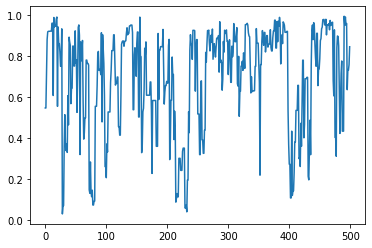

In [331]:
import seaborn as sns
sns.lineplot(x = range(len(probs)), y = probs)

In [332]:
masks = 

SyntaxError: invalid syntax (2265449847.py, line 1)

## Get explanatory model

In [333]:
import sklearn
from sklearn.metrics.pairwise import pairwise_distances
full_mask = copy.deepcopy(mask_bin)
full_mask[:] = 1
distances = pairwise_distances(masks, full_mask.reshape(1, -1)).ravel()

In [426]:
from lime.lime_image import ImageExplanation
from lime import lime_base
from sklearn.utils import check_random_state
from functools import partial

KERNEL_WIDTH = 4
def kernel(d):
    return np.sqrt(np.exp(-(d ** 2) / KERNEL_WIDTH ** 2))

random_state = check_random_state(None)
base = lime_base.LimeBase(kernel, False, random_state=random_state)
num_features=100000

ret_exp = ImageExplanation(image, segments)
ret_exp.top_labels = [39, 46, 43, 42, 41]
for label in [39, 46, 43, 42, 41]:
    (ret_exp.intercept[label],
     ret_exp.local_exp[label],
     ret_exp.score[label],
     ret_exp.local_pred[label]) = base.explain_instance_with_data(
        np.array(masks), np.array(labels), np.array(distances), np.array(label), num_features,
        model_regressor=None,
        feature_selection='auto')
explanation = ret_exp

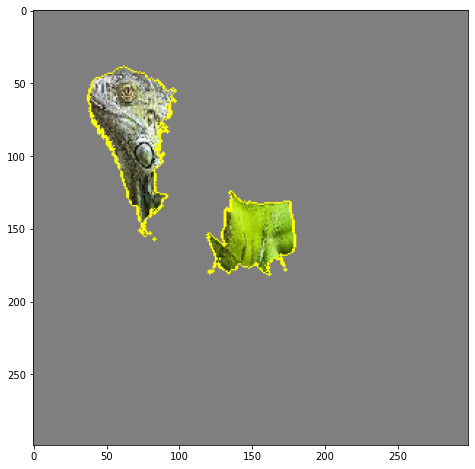

In [474]:
# Explanation for common_iguana
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.figure(figsize = (8,8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

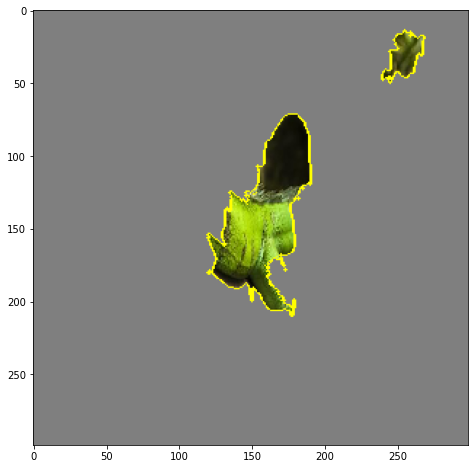

In [475]:
# Explanation for green_lizard
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.figure(figsize = (8,8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Comparison with random sampling

In [343]:
def random_sampling(index_of_interest, total_iters, image, fudged_image, segments, model):
    n_features = np.unique(segments).shape[0]
    labels = []
    masks = []
    probs = []
    for i in tqdm(range(total_iters)):
        mask_bin = np.array([random.randint(0, 1) for x in range(n_features)])
        masked_image = get_masked_image(image, fudged_image, mask_bin, segments)
        prob, preds = get_idx_prob_pred(index_of_interest, masked_image, inet_model)
        masks.append(mask_bin)
        probs.append(prob)
        labels.append(preds[0])
    
    return masks, probs, labels

In [345]:
random_masks, random_probs, random_labels = random_sampling(39, 500, image, fudged_image, segments, inet_model)

100%|████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.82it/s]


<AxesSubplot:>

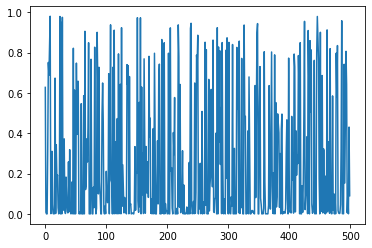

In [346]:
sns.lineplot(x = range(len(random_probs)), y = random_probs)

In [348]:
print("Average probability for random sampling: ", str(sum(random_probs)/len(random_probs)))
print("Average probability for MCMC sampling: ", str(sum(probs)/len(probs)))

Average probability for random sampling:  0.25436576972129227
Average probability for MCMC sampling:  0.6905965640209615


In [470]:
random_distances = pairwise_distances(random_masks, full_mask.reshape(1, -1)).ravel()

ret_exp = ImageExplanation(image, segments)
ret_exp.top_labels = [39, 46, 43, 42, 41]
for label in [39, 46, 43, 42, 41]:
    (ret_exp.intercept[label],
     ret_exp.local_exp[label],
     ret_exp.score[label],
     ret_exp.local_pred[label]) = base.explain_instance_with_data(
        np.array(random_masks), np.array(random_labels), np.array(random_distances), np.array(label), num_features,
        model_regressor=None,
        feature_selection='auto')
random_explanation = ret_exp

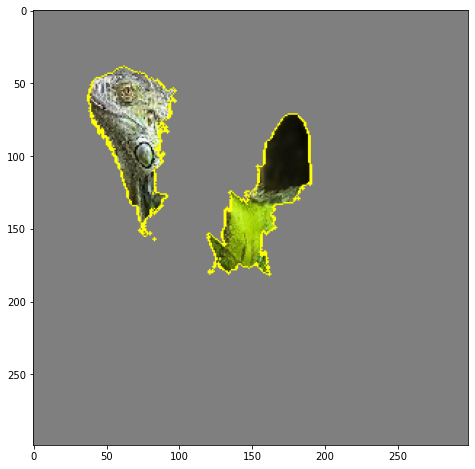

In [476]:
# Explanation for common_iguana
temp, mask = random_explanation.get_image_and_mask(random_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.figure(figsize = (8,8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## MCMC segment sample rate as importance

In [463]:
masks_transposed = np.array([list(x) for x in zip(*masks)])

In [464]:
sample_rates = [sum(x) / len(x) for x in masks_transposed]

In [459]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_model_attention(image, fudged_image, segments, sample_rates, threshold=0.5):
    temp = copy.deepcopy(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                mask_idx = segments[i][j]
                importance = sample_rates[mask_idx]
                temp[i][j][k] = temp[i][j][k] if importance >= threshold else 0
    return temp

<Figure size 432x288 with 0 Axes>

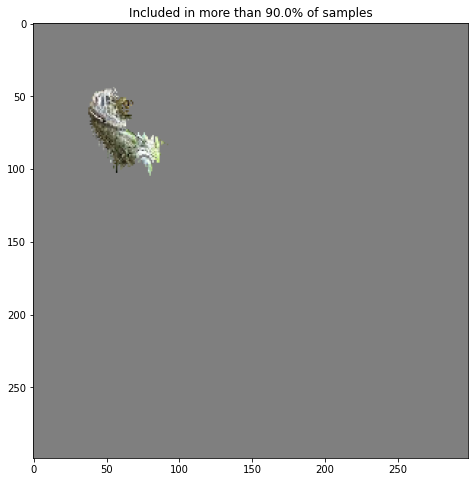

<Figure size 432x288 with 0 Axes>

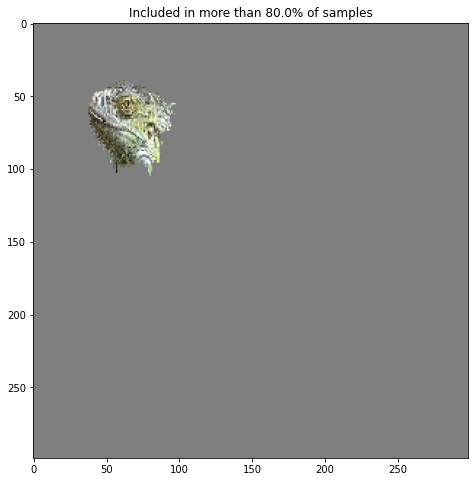

<Figure size 432x288 with 0 Axes>

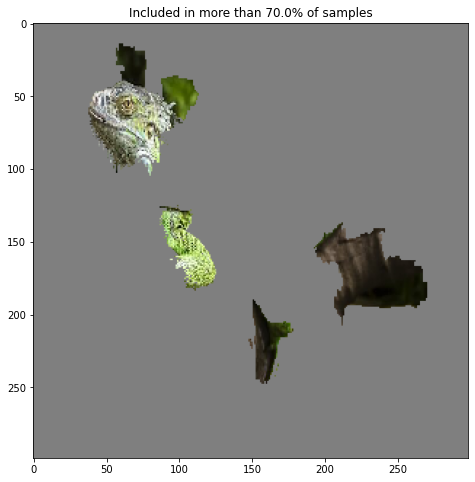

<Figure size 432x288 with 0 Axes>

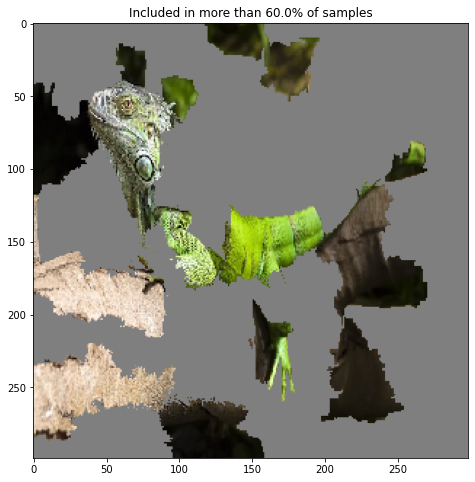

<Figure size 432x288 with 0 Axes>

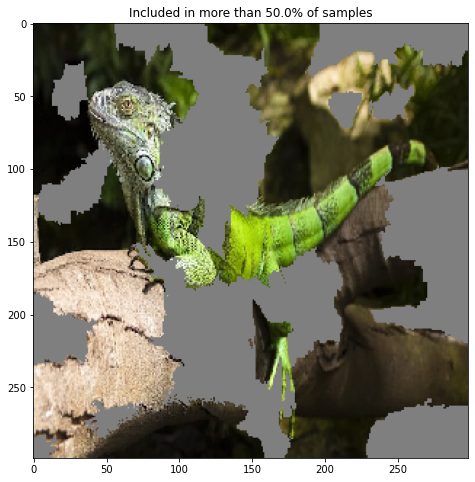

In [477]:
for t in [0.9, 0.8, 0.7, 0.6, 0.5]:
    attention = get_model_attention(image, fudged_image, segments, sample_rates, threshold=t)
    plt.figure()
    plt.figure(figsize = (8,8))
    plt.title("Included in more than " + str(100*t) + "% of samples")
    plt.imshow(attention/ 2 + 0.5)

## LIME segment coefficients as importance

<Figure size 432x288 with 0 Axes>

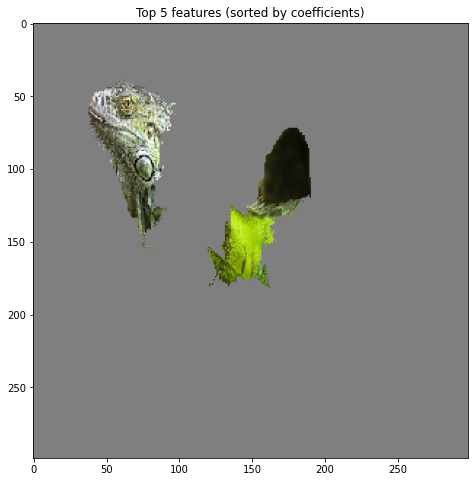

<Figure size 432x288 with 0 Axes>

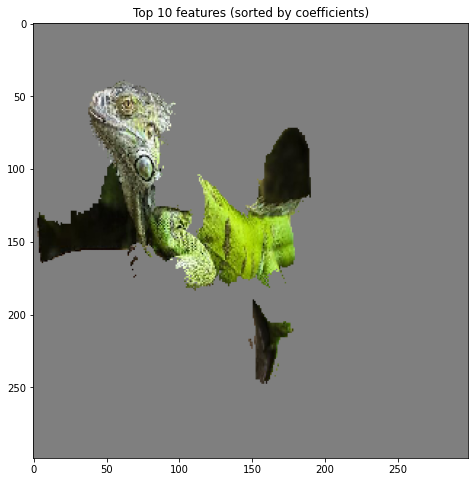

<Figure size 432x288 with 0 Axes>

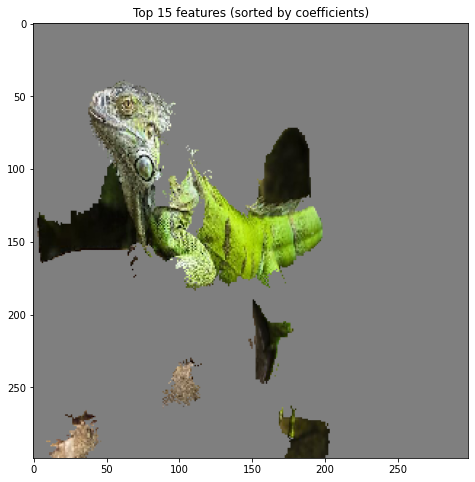

<Figure size 432x288 with 0 Axes>

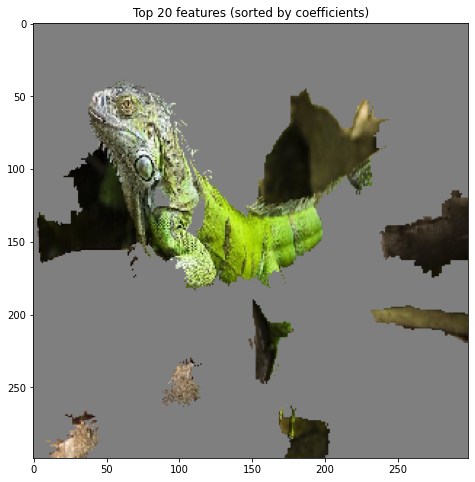

<Figure size 432x288 with 0 Axes>

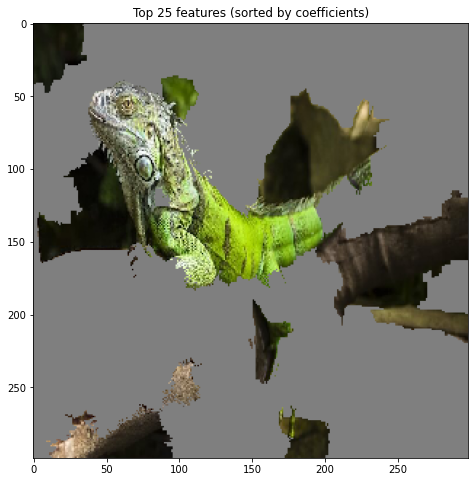

In [482]:
for c in [5, 10, 15, 20, 25]:
    temp, mask = random_explanation.get_image_and_mask(random_explanation.top_labels[0], positive_only=True, num_features=c, hide_rest=True)
    plt.figure()
    plt.figure(figsize = (8,8))
    plt.title("Top " + str(c) + " features (sorted by coefficients)")
    plt.imshow(temp / 2 + 0.5)

## MCMC segment coefficients as importance

<Figure size 432x288 with 0 Axes>

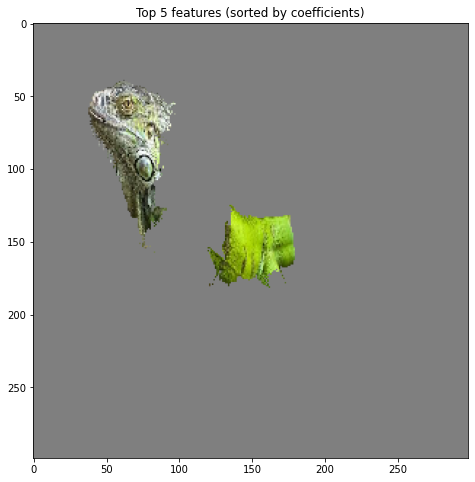

<Figure size 432x288 with 0 Axes>

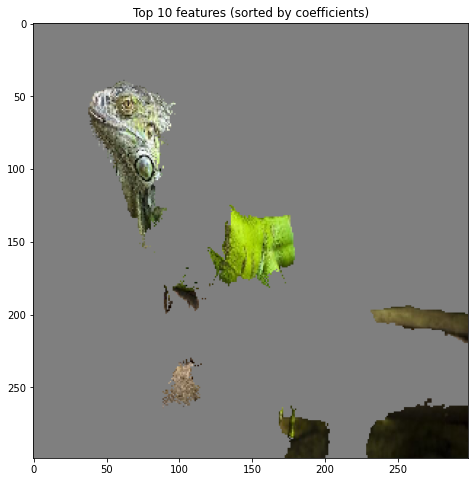

<Figure size 432x288 with 0 Axes>

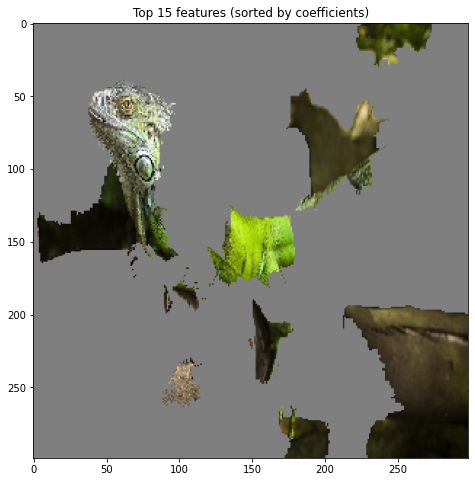

<Figure size 432x288 with 0 Axes>

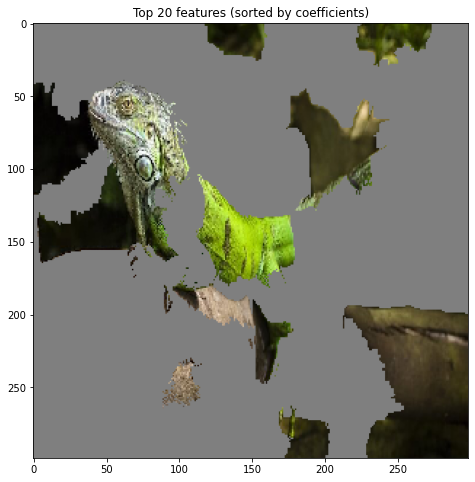

<Figure size 432x288 with 0 Axes>

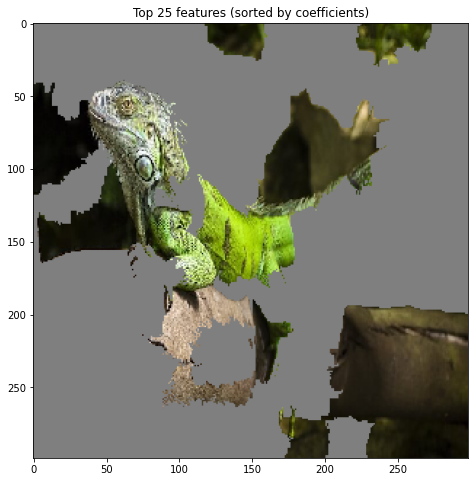

In [483]:
for c in [5, 10, 15, 20, 25]:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=c, hide_rest=True)
    plt.figure()
    plt.figure(figsize = (8,8))
    plt.title("Top " + str(c) + " features (sorted by coefficients)")
    plt.imshow(temp / 2 + 0.5)